# 클러스터링

In [26]:
import pandas as pd
from tsfresh import extract_features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA

In [27]:
def plot_elbow(X, max_k=10, title="Elbow Method"):
    inertias = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(K, inertias, 'o-', color="blue")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Within-cluster SSE)")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [28]:
def plot_silhouette(X, labels, title="Silhouette plot"):
    n_clusters = len(set(labels))
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            range(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(title)
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    plt.show()


In [29]:
df = pd.read_csv("../dataset/train/train.csv")

## Non-Hierarchical Clustering : KMeans

영업일자                    cluster
영업장명_메뉴명                       
느티나무 셀프BBQ_1인 수저세트            0
느티나무 셀프BBQ_BBQ55(단체)          2
느티나무 셀프BBQ_대여료 30,000원        0
느티나무 셀프BBQ_대여료 60,000원        0
느티나무 셀프BBQ_대여료 90,000원        0
...                         ...
화담숲카페_메밀미숫가루                  0
화담숲카페_아메리카노 HOT               0
화담숲카페_아메리카노 ICE               2
화담숲카페_카페라떼 ICE                0
화담숲카페_현미뻥스크림                  0

[193 rows x 1 columns]


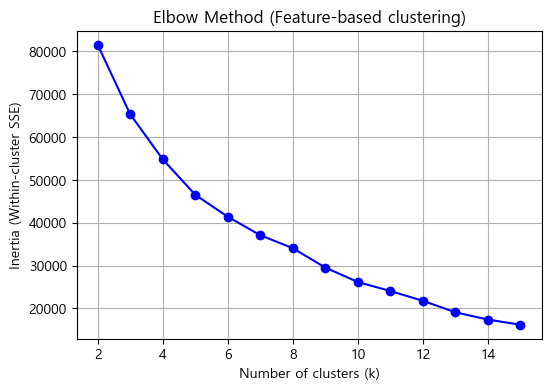

In [147]:
# 피벗 → 메뉴별 시계열 벡터화
pivot_df = df.pivot(index="영업일자", columns="영업장명_메뉴명", values="매출수량").fillna(0).T

# 정규화 (각 메뉴별 스케일 차이 제거)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels1 = kmeans.fit_predict(X_scaled)

# 결과 저장
pivot_df['cluster'] = labels1
print(pivot_df[['cluster']])

# 엘보우 방법 적용
plot_elbow(X_scaled, max_k=15, title="Elbow Method (Feature-based clustering)")

In [148]:
# X_scaled: 클러스터링에 쓴 데이터
# labels: 클러스터링 결과 레이블

print("Silhouette Score:", silhouette_score(X_scaled, labels1))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels1))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled, labels1))

Silhouette Score: 0.6874432022534657
Davies-Bouldin Index: 1.3876343178131887
Calinski-Harabasz Index: 47.218010716341645


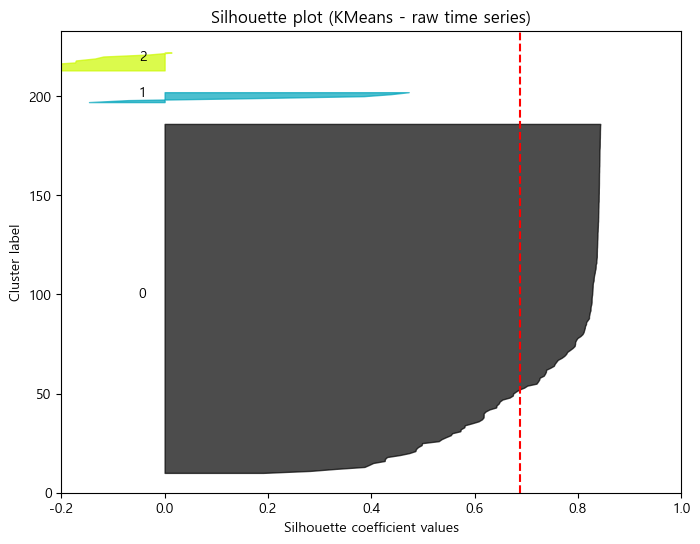

In [149]:
# 실루엣 그래프
plot_silhouette(X_scaled, labels1, title="Silhouette plot (KMeans - raw time series)")

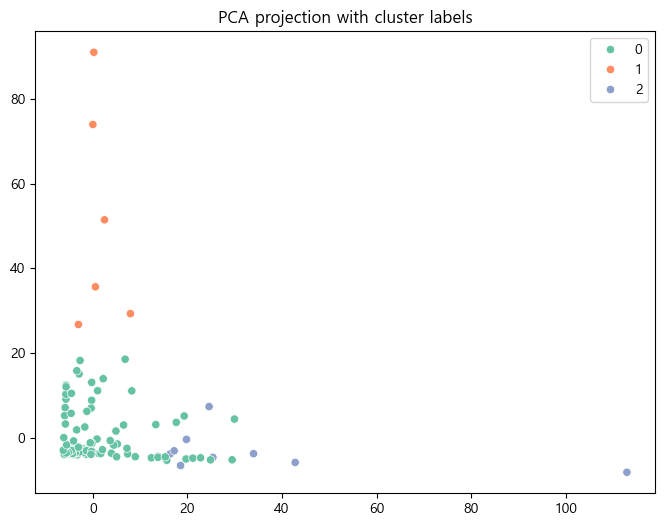

In [150]:
# 2차원 PCA 변환
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels1, palette="Set2")
plt.title("PCA projection with cluster labels")
plt.show()

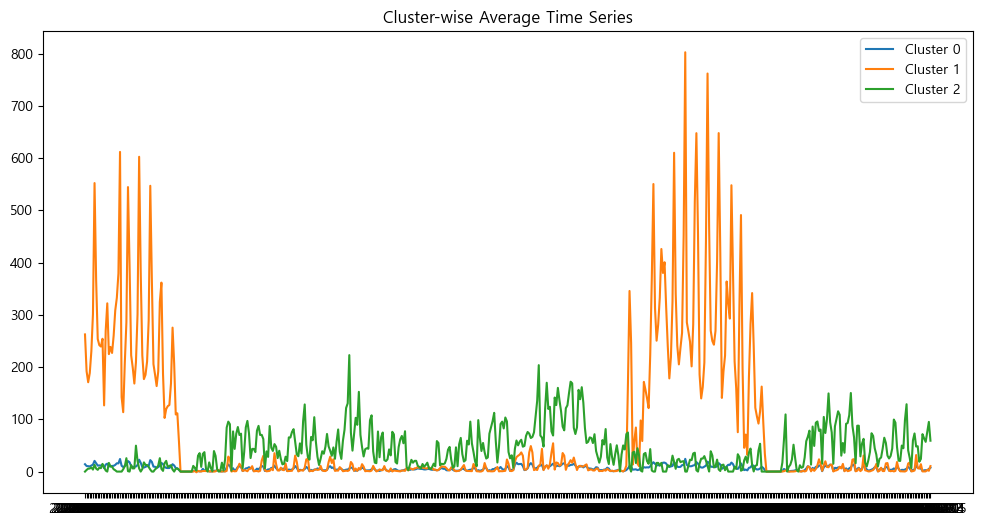

In [151]:
# 클러스터별 평균 시계열 그리기
pivot_df["cluster"] = labels1
cluster_means = pivot_df.groupby("cluster").mean().T

plt.figure(figsize=(12,6))
for c in cluster_means.columns:
    plt.plot(cluster_means.index, cluster_means[c], label=f"Cluster {c}")
plt.legend()
plt.title("Cluster-wise Average Time Series")
plt.show()

## Hierarchical Clustering : Euclidean + Ward, criterion = 'maxclust'

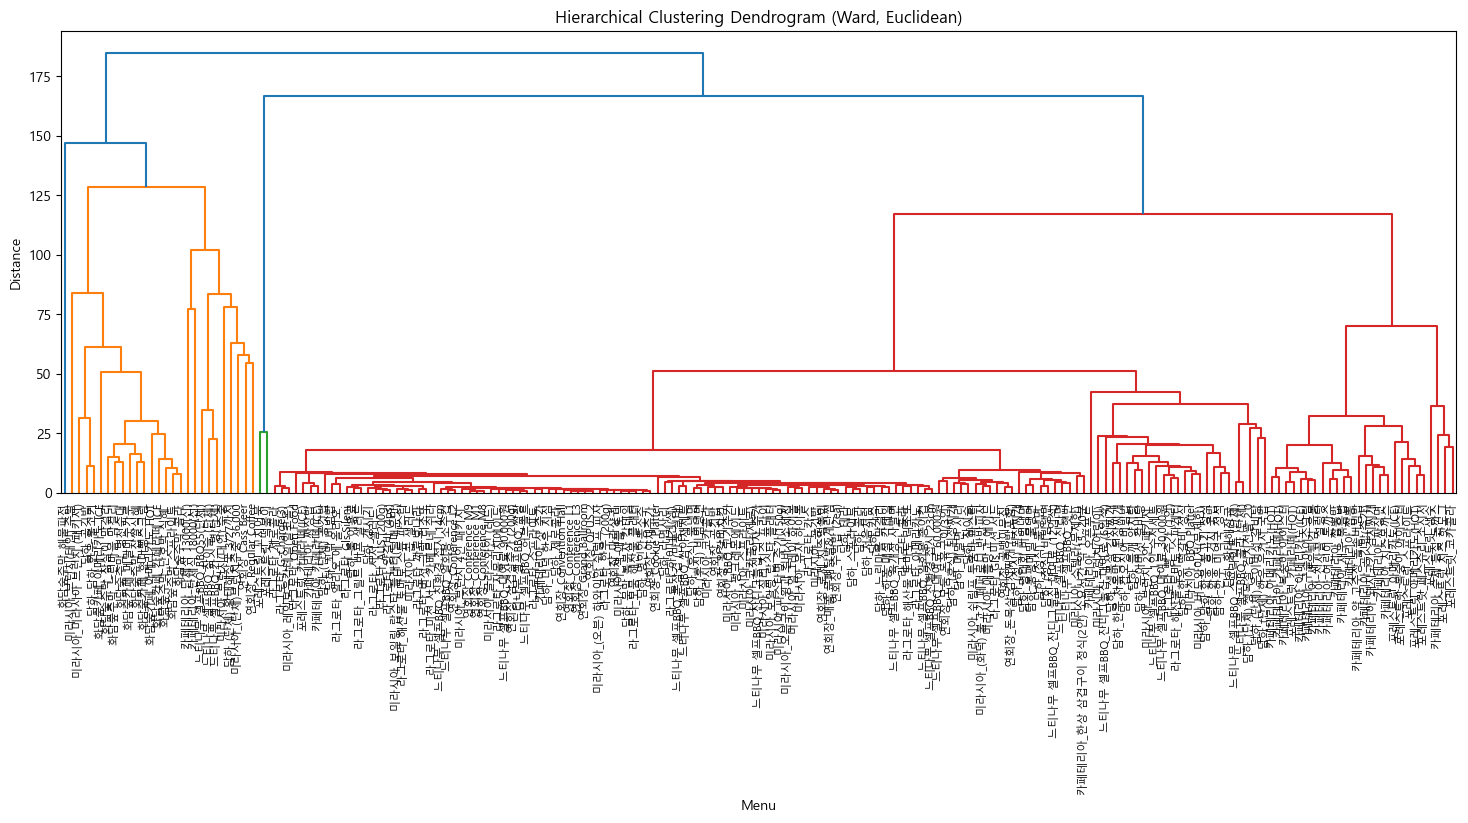

In [152]:
Z = linkage(X_scaled, method='ward', metric='euclidean')

# 덴드로그램 시각화
plt.figure(figsize=(18, 6))
dendrogram(Z, labels=pivot_df.index, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram (Ward, Euclidean)")
plt.xlabel("Menu")
plt.ylabel("Distance")
plt.show()

# k=5로 클러스터 자르기
k = 4
labels_hc = fcluster(Z, t=k, criterion='maxclust')
pivot_df['cluster'] = labels_hc

In [153]:
sil_score = silhouette_score(X_scaled, labels_hc)
db_score = davies_bouldin_score(X_scaled, labels_hc)
ch_score = calinski_harabasz_score(X_scaled, labels_hc)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Silhouette Score: 0.604
Davies-Bouldin Index: 1.091
Calinski-Harabasz Index: 45.720


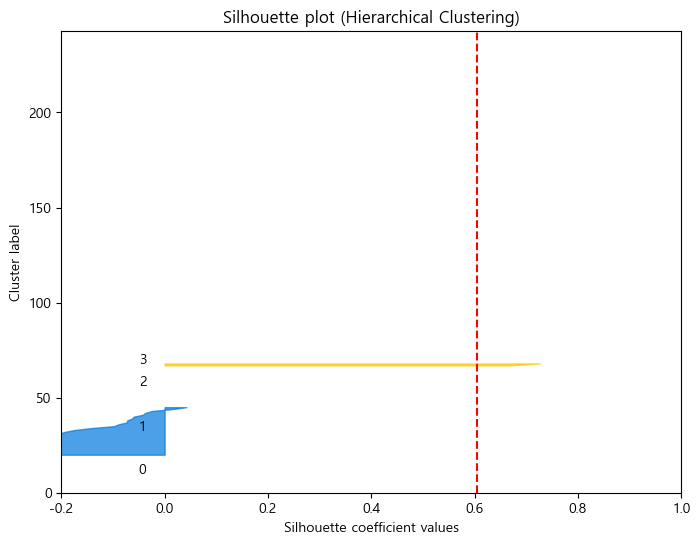

In [154]:
plot_silhouette(X_scaled, labels_hc, title="Silhouette plot (Hierarchical Clustering)")

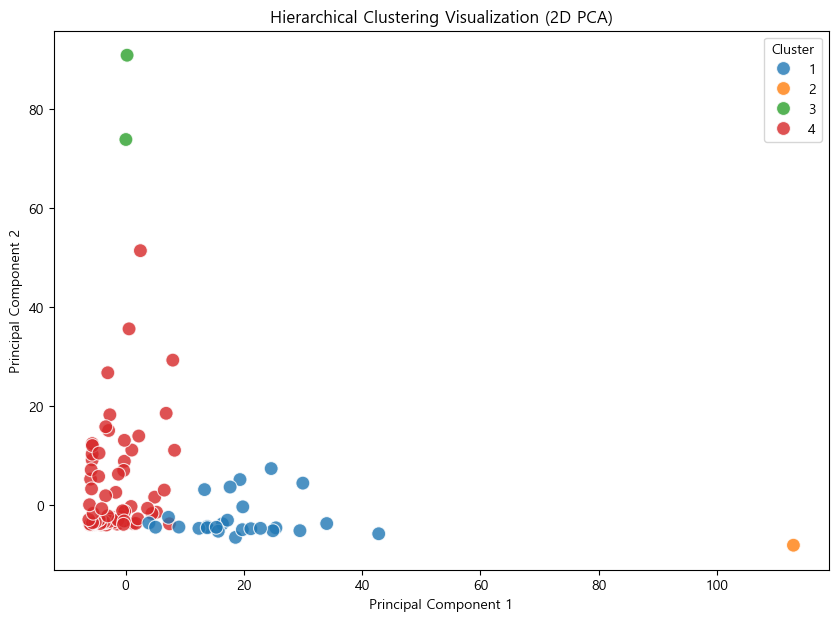

In [92]:
# 1. PCA 2D 변환
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. 데이터프레임 생성
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': labels_hc,
    'menu': pivot_df.index
})

# 3. 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100, alpha=0.8)
plt.title('Hierarchical Clustering Visualization (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

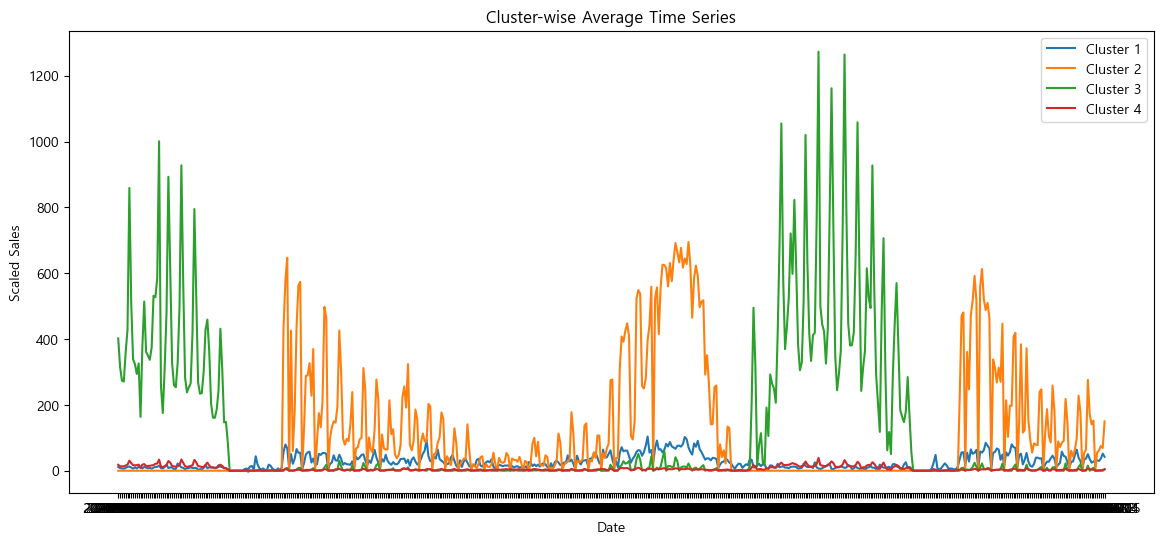

In [93]:
cluster_means = pivot_df.groupby("cluster").mean().T

plt.figure(figsize=(14, 6))
for c in cluster_means.columns:
    plt.plot(cluster_means.index, cluster_means[c], label=f"Cluster {c}")
plt.title("Cluster-wise Average Time Series")
plt.xlabel("Date")
plt.ylabel("Scaled Sales")
plt.legend()
plt.show()

## Hierarchical Clustering : Euclidean + Ward, criterion = 'distance'

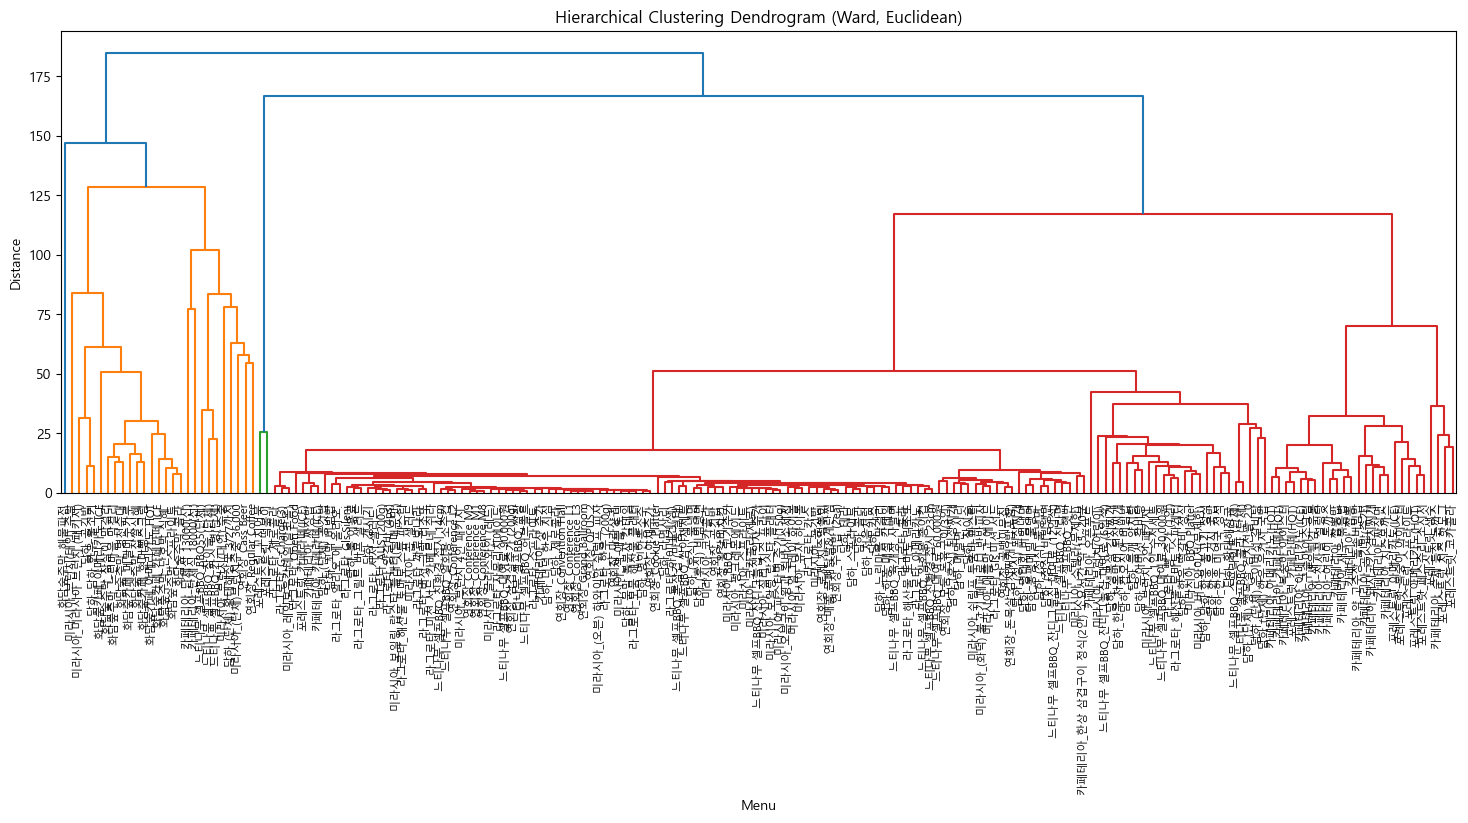

Distance 기준 클러스터 개수: 14


In [139]:
Z = linkage(X_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(18, 6))
dendrogram(Z, labels=pivot_df.index, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram (Ward, Euclidean)")
plt.xlabel("Menu")
plt.ylabel("Distance")
plt.show()

max_distance = 58  # 덴드로그램 보고 조정
labels_hc = fcluster(Z, t=max_distance, criterion='distance')
pivot_df['cluster'] = labels_hc
print("Distance 기준 클러스터 개수:", len(set(labels_hc)))

Silhouette Score: 0.468
Davies-Bouldin Index: 0.832
Calinski-Harabasz Index: 62.861


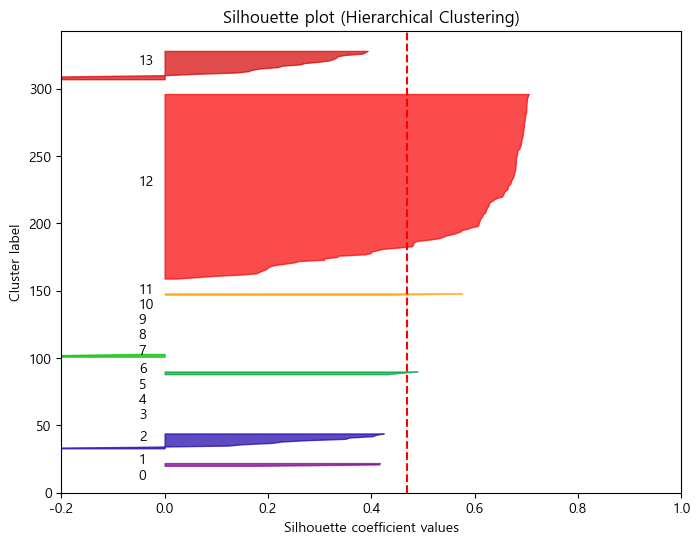

In [140]:
sil_score = silhouette_score(X_scaled, labels_hc)
db_score = davies_bouldin_score(X_scaled, labels_hc)
ch_score = calinski_harabasz_score(X_scaled, labels_hc)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

plot_silhouette(X_scaled, labels_hc, title="Silhouette plot (Hierarchical Clustering)")

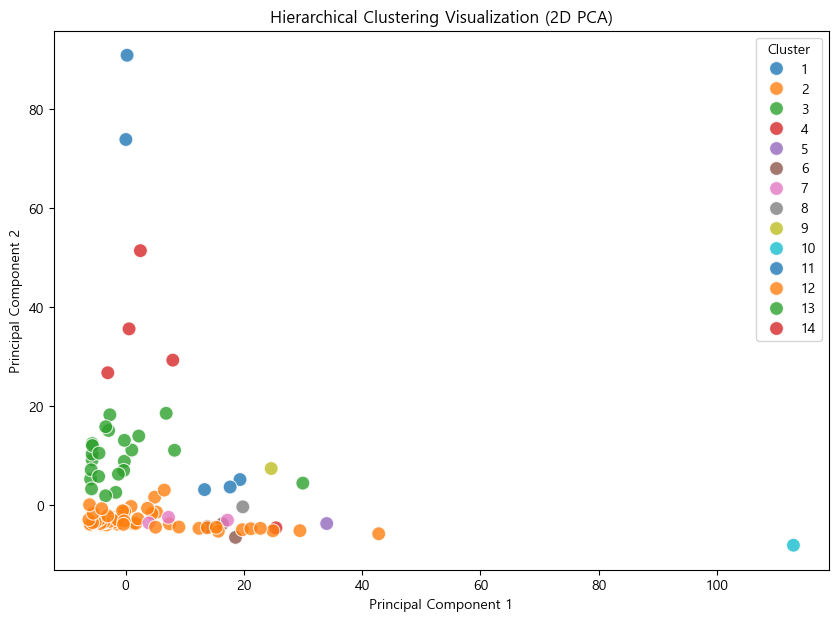

In [141]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': labels_hc,
    'menu': pivot_df.index
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100, alpha=0.8)
plt.title('Hierarchical Clustering Visualization (2D PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

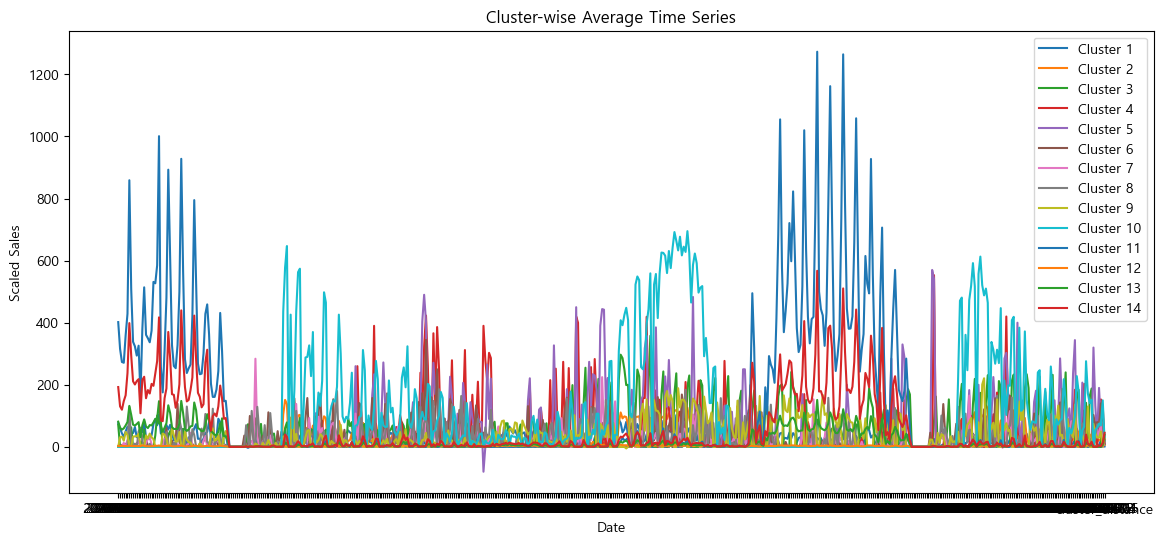

In [142]:
cluster_means = pivot_df.groupby("cluster").mean().T

plt.figure(figsize=(14, 6))
for c in cluster_means.columns:
    plt.plot(cluster_means.index, cluster_means[c], label=f"Cluster {c}")
plt.title("Cluster-wise Average Time Series")
plt.xlabel("Date")
plt.ylabel("Scaled Sales")
plt.legend()
plt.show()
